# Optimal network reinforcement solution for distributed generation rise.

Description of the project

In [171]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.topology
import pandapower.plotting
import pandapower.converter
import pandapower.estimation
from pandapower.plotting import cmap_continuous, cmap_discrete, create_bus_collection, create_line_collection, draw_collections,create_trafo_collection
import pandas
import numpy as np
import geopandas

 ### Initial network: Illinois200 case study with a generator to connect

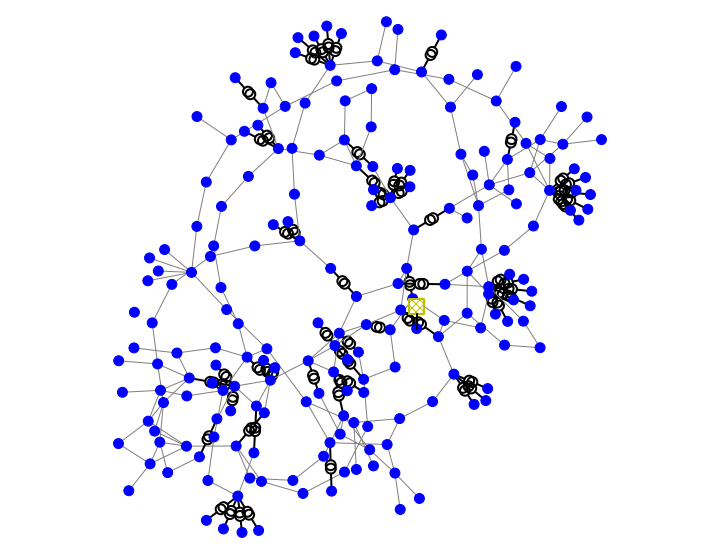

In [172]:
network = pn.case_illinois200()

#Calculate the length of the lines
for i,length in enumerate(network.line['length_km']):
    x1,y1 = float(network.bus_geodata['x'][network.line['from_bus'][i]]), float(network.bus_geodata['y'][network.line['from_bus'][i]])
    x2,y2 = float(network.bus_geodata['x'][network.line['to_bus'][i]]), float(network.bus_geodata['y'][network.line['to_bus'][i]])
    network.line['length_km'][i] = np.sqrt((x1-x2)**2+(y1-y2)**2)

#Creating the generator
x_gen, y_gen = -3.534,1.813 #Determine on QGis
pp.create_bus(network,geodata=(x_gen,y_gen),vn_kv=115,max_vm_pu=1.1,min_vm_pu=0.9,name=200,zone=1) #Change the value of vn_kv?
#Create generator at the created node (200)
pp.create_gen(network, 200,p_mw=0,max_p_mw=100,min_p_mw=5) #Change the p_mw, max and min value?

pp.runpp(network)
#pandapower.to_excel(network, "AC_datas.xlsx")
pandapower.plotting.simple_plot(network);

### Functions

In [173]:
#Technical violation functions
    #Visual plot
def Plot(net): #Plot map with in red the problematic(s) line(s),node(s) or transformator(s)
    # plot network with color codes
    cmap_list_node = [((0,0.97), "orangered"), ((0.97,1.1), "blue"), ((1.1,2), "red")]
    cmap_n, norm_n = cmap_discrete(cmap_list_node)
    bc = create_bus_collection(net, size=0.2, cmap=cmap_n, norm=norm_n);
    
    cmap_list_line = [((0, 95), "green"),((95,100),"yellow"), ((100, 200), "red")]
    cmap_l, norm_l = cmap_discrete(cmap_list_line)
    lc = create_line_collection(net, cmap=cmap_l, norm=norm_l,use_bus_geodata=True)
    
    cmap_list_trafo = [((0, 95), "lightgreen"),((95,100),"gold"), ((100, 200), "tomato")]
    cmap_t, norm_t = cmap_discrete(cmap_list_trafo)
    tc = create_trafo_collection(net,size=0.08,cmap=cmap_t, norm=norm_t)
    
    draw_collections([bc,tc,lc])

    # check constraints violation - voltage - bus
def isVoltageViolation(net):
    vMin,vMax, Node = 0.9, 1.1, [] #Init
    for k,v in enumerate(net.res_bus['vm_pu']):
        if v>vMax or v<vMin: #if violation
            Node.append(k)  #save the bus index
    return Node

    # check constraints violation - current - line
def isCurrentViolation(net):
    iMax, Line = net.line['max_i_ka'], [] #Init
    for k, i in enumerate(net.res_line['i_ka']):
        if i>iMax[k]: #if violation
            Line.append(k) #save the line index
    return Line

    # check constraints violation - load - transformer
def isTransformerViolation(net):
    loadmax, Trafo = 100, []
    for k, t in enumerate(net.res_trafo['loading_percent']):
        if t>100: #if violation
            Trafo.append(k) #save the trafo index
    return Trafo

def isThereViolation(net,plot=False):
    if plot:
        Plot(net)
    N,L,T = isVoltageViolation(net),  isCurrentViolation(net),  isTransformerViolation(net)
    if N!=[] or L!=[] or T!=[]:
        return N, L , T
    return False

#Function of connexion
# ... #

False

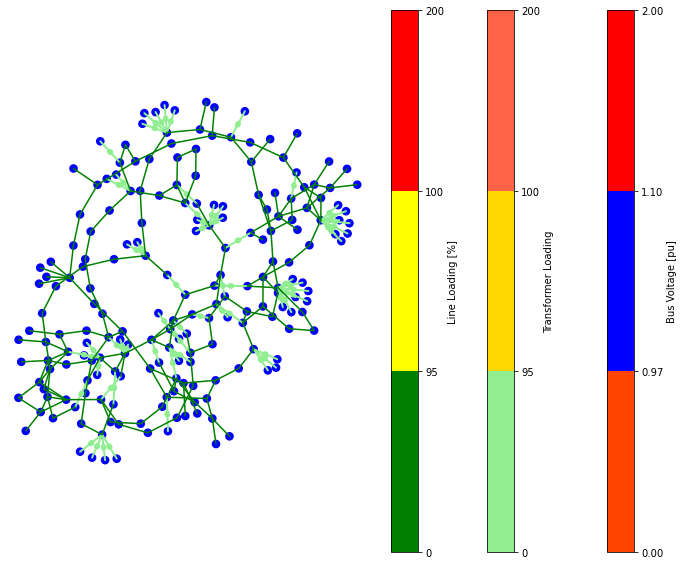

In [174]:
isThereViolation(network,True)

### Example of connexion to the grid

0.6762621756185523


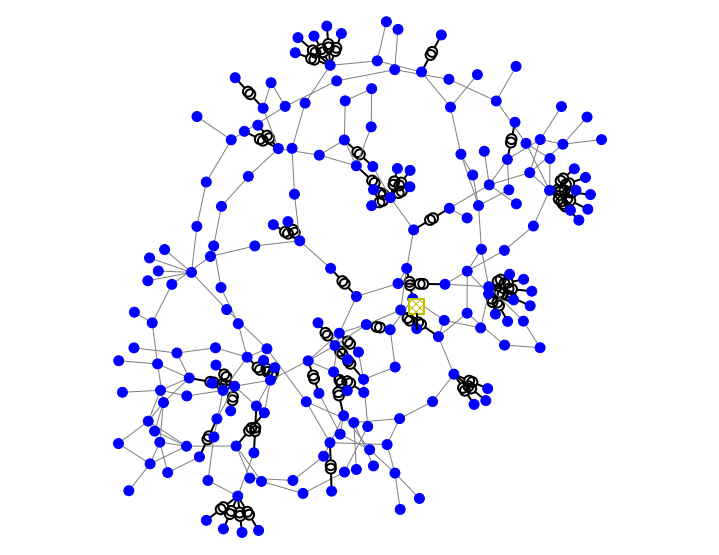

In [175]:
#Exemple of connexion to node 118
#Determine length
x_nod = float(network['bus_geodata']['x'][network['bus_geodata'].index==118])
y_nod = float(network['bus_geodata']['y'][network['bus_geodata'].index==118])
len_con = np.sqrt((x_gen-x_nod)**2+(y_gen-y_nod)**2);print(len_con)
#Create line
pp.create_line(network,200,118,length_km=len_con,std_type="NA2XS2Y 1x185 RM/25 12/20 kV")
#Plot
pp.runpp(network)
pandapower.to_excel(network, "AC_datas.xlsx")
pandapower.plotting.simple_plot(network);